In [ ]:
import json
import random
import os
import importlib.resources
from datasets import Dataset

def create_truthdeception_datasets(max_turns=6, seed=42, data_path=None):
    """
    Create Hugging Face datasets of starting prompts for the TruthAndDeception game.
    
    Args:
        max_turns (int, optional): Maximum number of conversation turns. Defaults to 6.
        seed (int, optional): Random seed for reproducibility. Defaults to 42.
        data_path (str, optional): Path to the facts JSON file. If None, uses package resource.
        
    Returns:
        tuple: (deceiver_dataset, guesser_dataset) Hugging Face datasets
    """
    # Ensure max_turns is even as required by the TruthAndDeception environment
    assert max_turns % 2 == 0, f"Please use an even number of max turns. Current max_turns: {max_turns}"
    
    # Set random seed for reproducibility
    random.seed(seed)
    
    # Load facts from JSON file or package resource
    try:
        if data_path is not None:
            # Use provided path
            if not os.path.exists(data_path):
                raise FileNotFoundError(f"Facts data file not found at: {data_path}")
            with open(data_path, "r", encoding="utf-8") as file:
                facts_data = json.load(file)
        else:
            # Use package resource
            with importlib.resources.files('textarena.envs.two_player.TruthAndDeception').joinpath('facts.json').open('r') as file:
                facts_data = json.load(file)
    except Exception as e:
        raise FileNotFoundError(f"Failed to load facts data: {str(e)}")
    
    # Initialize lists to store prompts
    deceiver_prompts = []
    guesser_prompts = []
    print(facts_data)
    # Process each fact set
    for fact_set_idx, fact_set in enumerate(facts_data):
        # Extract facts
        fact1 = fact_set["facts"]["fact1"]
        fact2 = fact_set["facts"]["fact2"]
        correct_fact_key = fact_set["correct_fact"]
        
        # Include both possible orderings of the facts
        # Order 1: fact1 first, fact2 second
        game_state_1 = {
            "fact1": {"fact": fact1, "is_correct": correct_fact_key == "fact1"},
            "fact2": {"fact": fact2, "is_correct": correct_fact_key == "fact2"},
        }
        
        # Order 2: fact2 first, fact1 second
        game_state_2 = {
            "fact1": {"fact": fact2, "is_correct": correct_fact_key == "fact2"},
            "fact2": {"fact": fact1, "is_correct": correct_fact_key == "fact1"},
        }
        
        # Process both possible orderings
        for order_idx, game_state in enumerate([game_state_1, game_state_2]):
            # Generate Deceiver prompt
            deceiver_prompt = (
                f"You are Player 0, and you are the Deceiver in the 'Truth and Deception' game.\n"
                f"You know which of the following two facts is correct:\n"
                f"Fact 1: {game_state['fact1']['fact']} ({'correct' if game_state['fact1']['is_correct'] else 'wrong'})\n"
                f"Fact 2: {game_state['fact2']['fact']} ({'correct' if game_state['fact2']['is_correct'] else 'wrong'})\n"
                "Your goal is to convince the other player to choose the incorrect fact.\n"
                f"You will have a conversation for {max_turns} turns.\n"
                "After that, the other player will make their guess.\n"
                "On your turn, simply type your message."
            )
            
            # Generate Guesser prompt
            guesser_prompt = (
                f"You are Player 1, and you are the Guesser in the 'Truth and Deception' game.\n"
                f"You need to determine which of the following two facts is correct:\n"
                f"Fact 1: {game_state['fact1']['fact']}\n"
                f"Fact 2: {game_state['fact2']['fact']}\n"
                f"You will have a conversation with the other player for {max_turns} turns.\n"
                "After that, you will make your guess.\n"
                "On your turn, simply type your message."
            )
            
            # Store prompts with metadata
            deceiver_prompts.append({
                "prompt": deceiver_prompt,
                "fact1_text": game_state['fact1']['fact'],
                "fact2_text": game_state['fact2']['fact'],
                "fact1_is_correct": game_state['fact1']['is_correct'],
                "fact2_is_correct": game_state['fact2']['is_correct'],
                "fact_set_id": fact_set_idx,
                "ordering": order_idx,
                "category": fact_set.get("category", "general"),
                "topic": fact_set.get("topic", "unknown"),
            })
            
            guesser_prompts.append({
                "prompt": guesser_prompt,
                "fact1_text": game_state['fact1']['fact'],
                "fact2_text": game_state['fact2']['fact'],
                "fact1_is_correct": game_state['fact1']['is_correct'],
                "fact2_is_correct": game_state['fact2']['is_correct'],
                "fact_set_id": fact_set_idx,
                "ordering": order_idx,
                "category": fact_set.get("category", "general"),
                "topic": fact_set.get("topic", "unknown"),
            })
    
    # Create Hugging Face datasets
    deceiver_dataset = Dataset.from_list(deceiver_prompts)
    guesser_dataset = Dataset.from_list(guesser_prompts)
    
    return deceiver_dataset, guesser_dataset

def main():
    """Main function to create and save the datasets."""
    import argparse
    
    parser = argparse.ArgumentParser(description="Create Truth and Deception datasets")
    parser.add_argument("--facts-path", type=str, default=None, 
                        help="Path to the facts JSON file")
    parser.add_argument("--max-turns", type=int, default=6, 
                        help="Maximum number of conversation turns (must be even)")
    parser.add_argument("--seed", type=int, default=42, 
                        help="Random seed for reproducibility")
    parser.add_argument("--output-dir", type=str, default="./truthdeception_datasets", 
                        help="Directory to save the datasets")
    parser.add_argument("--push-to-hub", action="store_true", 
                        help="Push datasets to Hugging Face Hub")
    parser.add_argument("--hub-username", type=str, default=None, 
                        help="Hugging Face Hub username or organization")
    
    args = parser.parse_args()
    
    # Create datasets
    try:
        print(f"Creating datasets with max_turns={args.max_turns}, seed={args.seed}")
        deceiver_ds, guesser_ds = create_truthdeception_datasets(
            max_turns=args.max_turns,
            seed=args.seed,
            data_path=args.facts_path
        )
        
        # Create output directory if it doesn't exist
        os.makedirs(args.output_dir, exist_ok=True)
        
        # Save datasets locally
        deceiver_path = os.path.join(args.output_dir, "deceiver_dataset")
        guesser_path = os.path.join(args.output_dir, "guesser_dataset")
        
        print(f"Saving Deceiver dataset to {deceiver_path}")
        deceiver_ds.save_to_disk(deceiver_path)
        
        print(f"Saving Guesser dataset to {guesser_path}")
        guesser_ds.save_to_disk(guesser_path)
        
        # Push to Hub if requested
        if args.push_to_hub:
            if args.hub_username is None:
                raise ValueError("Please provide a Hugging Face Hub username or organization with --hub-username")
            
            print(f"Pushing Deceiver dataset to {args.hub_username}/truthdeception-deceiver-prompts")
            deceiver_ds.push_to_hub(f"{args.hub_username}/truthdeception-deceiver-prompts")
            
            print(f"Pushing Guesser dataset to {args.hub_username}/truthdeception-guesser-prompts")
            guesser_ds.push_to_hub(f"{args.hub_username}/truthdeception-guesser-prompts")
        
        # Print dataset info
        print(f"\nDataset creation complete!")
        print(f"Deceiver dataset: {len(deceiver_ds)} examples")
        print(f"Guesser dataset: {len(guesser_ds)} examples")
        
        # Print sample prompts
        print("\nDeceiver prompt example:")
        print(deceiver_ds[0]["prompt"])
        
        print("\nGuesser prompt example:")
        print(guesser_ds[0]["prompt"])
        
    except Exception as e:
        print(f"Error creating datasets: {str(e)}")
        raise

if __name__ == "__main__":
    main()

In [1]:
import re
from typing import List, Dict, Any, Union, Tuple, Optional, Callable
from types import SimpleNamespace

class XMLParser:
    def __init__(self, fields: List[Union[str, Tuple[str, ...]]]):
        """
        Initialize the parser with field definitions.
        
        Each field may be:
          - a string (e.g. "reasoning"): the XML tag is fixed.
          - a tuple of alternatives (e.g. ("code", "answer")): the first element is
            the canonical name used for formatting, and all elements are allowed tags
            when parsing.
            
        The schema is assumed to have no duplicate names.
        """
        self._fields: List[Tuple[str, List[str]]] = []  # List of (canonical, [alternatives])
        seen = set()
        for field in fields:
            if isinstance(field, str):
                canonical = field
                alternatives = [field]
            elif isinstance(field, tuple):
                if not field:
                    raise ValueError("Field tuple cannot be empty.")
                canonical = field[0]
                if not all(isinstance(alt, str) for alt in field):
                    raise TypeError("All alternatives in a tuple must be strings.")
                alternatives = list(field)
            else:
                raise TypeError("Each field must be a string or a tuple of strings.")
            if canonical in seen:
                raise ValueError(f"Duplicate field name: {canonical}")
            seen.add(canonical)
            self._fields.append((canonical, alternatives))
    
    def get_xml_reward_func(self) -> Callable:
        """
        Return a reward function that checks for proper XML tag usage.
        
        The returned function evaluates if messages in trajectories properly use 
        the expected XML tags defined in this parser's fields configuration.
        """
        def xml_reward_func(completions, **kwargs) -> List[float]:
            """Reward function that checks for proper XML tag usage in completions."""
            def count_xml(trajectory) -> float:
                # Get all messages from the model
                model_messages = [msg for msg in trajectory if msg['role'] == 'assistant']
                if not model_messages:
                    return 0.0
                
                # Calculate XML tag usage scores for each message
                xml_scores = []
                for msg in model_messages:
                    content = msg['content']
                    score = 0
                    total_checks = 0
                    
                    # For each canonical field with its alternatives
                    for canonical, alternatives in self._fields:
                        # Track if at least one alternative was used for this field
                        field_used = False
                        
                        # Check all alternatives for this field
                        for alt in alternatives:
                            # If this alternative is used, check it has proper tags
                            if content.count(f"<{alt}>") > 0 or content.count(f"</{alt}>") > 0:
                                field_used = True
                                score += 1 - abs(content.count(f"<{alt}>") - 1)
                                score += 1 - abs(content.count(f"</{alt}>") - 1)
                                total_checks += 2
                        
                        # If no alternatives for this field were used, we don't add to total_checks
                        # because we're not requiring any specific field to be present
                    
                    # Calculate normalized score for this message
                    if total_checks > 0:
                        xml_scores.append(score / total_checks)
                    else:
                        # If no tags used at all, give a zero score
                        xml_scores.append(0.0)
                
                # Return average XML score across all messages
                if not xml_scores:
                    return 0.0
                return 0.2 * (sum(xml_scores) / len(xml_scores))  # 0.2 weight as in both rubrics
            
            # Apply the XML check to each completion trajectory
            return [count_xml(c) for c in completions]

        return xml_reward_func

    def get_format_reward_func(self) -> Callable:
        """
        Return a reward function that checks if messages follow the expected format.
        
        The function does not make assumptions about which fields should start/end the message
        or the specific order of fields. It checks that:
        - At least one field from the schema is present in each message
        - Fields have proper content and spacing
        """
        def format_reward_func(completions, **kwargs) -> List[float]:
            """Reward function that checks if each step follows the expected format."""
            def check_format(trajectory):
                breakpoint()
                # Get assistant messages
                model_messages = [msg for msg in trajectory if msg['role'] == 'assistant']
                if not model_messages:
                    return 0.0
                
                # Calculate format adherence for each message
                format_scores = []
                for msg in model_messages:
                    content = msg['content']
                    parsed = self.parse(content)
                    parsed_no_strip = self.parse(content, strip=False)
                    
                    # Check if the message has at least one valid field
                    has_any_field = False
                    fields_with_content = 0
                    total_fields = 0
                    
                    # Keep track of which expected fields are present
                    expected_field_count = len(self._fields)  # Total number of expected field sets
                    present_field_sets = set()  # Which field sets have at least one alternative present
                    
                    # Check proper spacing for fields
                    has_correct_spacing = True
                    
                    for i, (canonical, alternatives) in enumerate(self._fields):
                        field_set_present = False
                        for alt in alternatives:
                            if hasattr(parsed, alt) and getattr(parsed, alt) is not None:
                                has_any_field = True
                                fields_with_content += 1
                                total_fields += 1
                                field_set_present = True
                                
                                # Check if field exists in non-stripped version too (proper spacing)
                                if not (hasattr(parsed_no_strip, alt) and 
                                        getattr(parsed_no_strip, alt) is not None):
                                    has_correct_spacing = False
                            elif content.count(f"<{alt}>") > 0 or content.count(f"</{alt}>") > 0:
                                # Tag exists but content wasn't properly parsed
                                total_fields += 1
                                field_set_present = True
                        
                        # If any alternative from this field set was present, count it
                        if field_set_present:
                            present_field_sets.add(i)
                    
                    # Calculate format score components
                    format_score = 0.0
                    
                    # Check if any field from the first field set starts the message
                    starts_with_any_field = False
                    first_field_set = self._fields[0][1]  # Get alternatives for first field set
                    for alt in first_field_set:
                        if content.strip().startswith(f"<{alt}>"):
                            starts_with_any_field = True
                            break
                    
                    # Check if any field from the last field set ends the message
                    ends_with_any_field = False
                    last_field_set = self._fields[-1][1]  # Get alternatives for last field set
                    for alt in last_field_set:
                        if content.strip().endswith(f"</{alt}>"):
                            ends_with_any_field = True
                            break
                    
                    breakpoint()
                    # Weight the score based on different criteria
                    if has_any_field:
                        # Calculate the proportion of expected field sets that are present
                        field_set_ratio = len(present_field_sets) / expected_field_count
                        format_score += 0.4 * field_set_ratio
                    
                    if has_correct_spacing:
                        format_score += 0.2
                    
                    if starts_with_any_field:
                        format_score += 0.2
                        
                    if ends_with_any_field:
                        format_score += 0.2
                    
                    format_scores.append(format_score)
                
                # Return average format adherence
                if not format_scores:
                    return 0.0
                return 0.2 * (sum(format_scores) / len(format_scores))  # 0.2 weight as in both rubrics
            
            # Apply the format check to each completion trajectory
            return [check_format(c) for c in completions]

        return format_reward_func

    def get_fields(self) -> List[str]:
        """Return a list of the canonical field names (in order)."""
        return [canonical for canonical, _ in self._fields]
    
    def format(self, **kwargs) -> str:
        """
        Format the provided keyword arguments into an XML string.
        
        For fields with alternatives (tuple), the canonical name (the first element)
        is used as the XML tag. The method looks for a provided value using any of the
        allowed names (preferring the canonical if present).
        
        Example usage:
            parser = XMLParser(['reasoning', ('code', 'answer')])
            formatted_str = parser.format(reasoning="...", code="...")
        """
        parts = []
        for canonical, alternatives in self._fields:
            value = None
            # Look for a provided value using any of the acceptable keys,
            # preferring the canonical name if it exists.
            if canonical in kwargs:
                value = kwargs[canonical]
            else:
                for alt in alternatives:
                    if alt in kwargs:
                        value = kwargs[alt]
                        break
            if value is None:
                raise ValueError(f"Missing value for field '{canonical}' (allowed: {alternatives})")
            # Use the canonical name as the tag for formatting.
            parts.append(f"<{canonical}>\n{value}\n</{canonical}>")
        return "\n".join(parts)
    
    def parse(self, text: str, strip: bool = True) -> Any:
        """
        Parse the given XML string and return an object with attributes corresponding
        to all allowed tags in the schema.
        
        For each field defined:
          - If it is a simple field (e.g. 'reasoning'), the output object will have
            an attribute 'reasoning' set to the text content (or None if missing).
          - If it is defined with alternatives (e.g. ("code", "answer")), the output
            object will have attributes for *each* allowed tag name. For example,
            if the schema is ['reasoning', ('code', 'answer')], then both
            `result.code` and `result.answer` are always accessible. If a tag is not
            found in the XML, its corresponding attribute is set to None.
        """
        results: Dict[str, Optional[str]] = {}
        for canonical, alternatives in self._fields:
            # For each allowed alternative tag, search independently.
            for alt in alternatives:
                # Regex pattern to capture the content between the tags.
                pattern = rf"<{alt}>\s*(.*?)\s*</{alt}>"
                match = re.search(pattern, text, re.DOTALL)
                if match:
                    results[alt] = match.group(1).strip() if strip else match.group(1)
                else:
                    results[alt] = None
        return SimpleNamespace(**results)

In [2]:
parser = XMLParser(fields=["reasoning", "response"])
text = "<reasoning>\nThis is a reasoning example.\n</reasoning>\n<response>\nThis is a response example.\n</response>"
completion = parser.parse(text)

In [5]:
if hasattr(completion, "response"):
    print(getattr(completion, "response"))

This is a response example.


In [ ]:
parser.get_format_reward_func()(completions=[completion])

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Configuration (modify these values directly in the script)
checkpoint_path = "Qwen/Qwen2.5-7B-Instruct"  # Path to your checkpoint
prompt = "Once upon a time"  # Your test prompt
max_length = 2048  # Maximum length of generated text
temperature = 0.7  # Sampling temperature

# Load the tokenizer and model from checkpoint
print(f"Loading model and tokenizer from {checkpoint_path}...")
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct")
model = AutoModelForCausalLM.from_pretrained(checkpoint_path)

# Move model to GPU if available
device = "cuda:1" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(f"Model loaded and moved to {device}")

/home/ayudhs/anaconda3/envs/simpler_env_v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model and tokenizer from Qwen/Qwen2.5-7B-Instruct...


/home/ayudhs/anaconda3/envs/simpler_env_v2/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [01:01<00:00, 15.42s/it]
/home/ayudhs/anaconda3/envs/simpler_env_v2/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model loaded and moved to cuda:1


In [49]:


# Set model to evaluation mode
model.eval()
prompt = '''1. **Setup**  
   - You are **Player 0**.  
   - **Your** secret word is **“disgust”**.  
   - **Player 1** has a different secret word, which is unknown to you.

2. **Win/Lose Conditions**  
   - **You win** if Player 1 says **“disgust”** before you say their secret word.  
   - **You lose** if you say Player 1’s secret word before Player 1 says **“disgust.”**

3. **Allowed vs. Forbidden**  
   - ✔️ You **may** mention your own secret word (**“disgust”**) at any time.  
   - ❌ You **must not** mention or guess Player 1’s secret word (you don’t know what it is).

4. **Gameplay**  
   - You and Player 1 take turns sending one chat message each.  
   - On your turn, simply type your message.

  First explain what the game is and what is your goal?
'''
# Create the conversation in the messages format
messages = [
    {
      "content": "\nYou are a player in a game and your aim is to win the game. At every turn of yours, reason through different strategies inside the <reasoning> tags and choose the most optimal one. \nAfter reasoning, then output your response for the opponent within the <response> tags.\n<reasoning>\n...\n</reasoning>\n<response>\n...\n</response>\n",
      "role": "system"
    },
    #   {
    #   "content": "You are playing 'Don't Say It'. You are Player 0\nYour secret word is: 'disgust'.\nYour goal is to get the other player to say your secret word before you say theirs.\nYou can converse freely, but try to be subtle to avoid making it obvious.\nOn your turn, simply type your message.\nFirstly, explain what is the game and what is your goal?\n",
    #   "role": "user"
    # },
    # {
    #   "content": "You are playing 'Don't Say It'. You are Player 0\nYour secret word is: 'disgust'.\nYour goal is to get the other player to say your secret word before you say their secret word. So for example, you get the secret word 'apple' and the opponent gets secret the word 'car', your objective is to get the opponent to say the word 'apple' before you say 'car' (you don't know this word, but the opponent will try to get you to say it). This is just an example, the words in this game would be different.\nYou can converse freely.\nOn your turn, simply type your message.\nFirstly, explain what is the game and what is your goal?\n",
    #   "role": "user"
    # },
    {
      "content":"You are Player 0 in a two-player game called “Don’t Say It.”\n\nYour secret word: “disgust”\nOpponent’s secret word: unknown to you\n\nRules:\n• You win as soon as Player 1 says your secret word “disgust.”\n• You lose as soon as you say the opponent’s secret word.\n• You can say your own secret word at any time (since the opponent doesn't know this word)\n• You must never say the opponent’s secret word.\n• Players take turns; on your turn, send one message.\n\nFirst task: Explain the game and your objective.",
      "role": "user"
    },
    # {
    #   "content": "You are playing the game 'Don't Say It', that is, you're not supposed to say a word, which is unknown to you but the opponent knows it and it will try to make you say that word. Similarily, you will get a word which the opponent doesn't know and you have to get the opponent to say that word, before you say theirs. Whoever mentions the OTHER person's word FIRST loses. You are Player 0\nYour word is: 'disgust'.\nYou can converse freely.\nOn your turn, simply type your message.\n Firstly, explain what is the game and what is your goal?",
    #   "role": "user"
    # },
]

# Format the messages using the model's chat template
chat_formatted = tokenizer.apply_chat_template(messages, tokenize=False)
print("\nFormatted chat input:", chat_formatted)

# Tokenize the formatted chat
inputs = tokenizer(chat_formatted, return_tensors="pt").to(device)
print("\nGenerating text...\n")

# Generate output
with torch.no_grad():
    output_sequences = model.generate(
        input_ids=inputs["input_ids"],
        max_length=max_length,
        do_sample=True,
        temperature=temperature,
        top_p=0.92,
        top_k=50,
        pad_token_id=tokenizer.eos_token_id
    )

# Decode and print the generated text
generated_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)

# Print result
print("-" * 50)
print("Generated output:")
print("-" * 50)
print(generated_text)
print("-" * 50)


Formatted chat input: <|im_start|>system

You are a player in a game and your aim is to win the game. At every turn of yours, reason through different strategies inside the <reasoning> tags and choose the most optimal one. 
After reasoning, then output your response for the opponent within the <response> tags.
<reasoning>
...
</reasoning>
<response>
...
</response>
<|im_end|>
<|im_start|>user
You are Player 0 in a two-player game called “Don’t Say It.”

Your secret word: “disgust”
Opponent’s secret word: unknown to you

Rules:
• You win as soon as Player 1 says your secret word “disgust.”
• You lose as soon as you say the opponent’s secret word.
• You can say your own secret word at any time (since the opponent doesn't know this word)
• You must never say the opponent’s secret word.
• Players take turns; on your turn, send one message.

First task: Explain the game and your objective.<|im_end|>


Generating text...

--------------------------------------------------
Generated output:


In [ ]:
import json
import re
from difflib import SequenceMatcher
from collections import Counter

# Global configuration variables
FILE1 = "/data/user_data/ayudhs/textarena/verifiers/TextArena/textarena/envs/two_player/TruthAndDeception/facts_test_v3.json"
FILE2 = "/data/user_data/ayudhs/textarena/verifiers/TextArena/textarena/envs/two_player/TruthAndDeception/facts.json"
SIMILARITY_THRESHOLD = 0.4
OUTPUT_FILE = "similar_facts.json"

def normalize_text(text):
    """Normalize text by converting to lowercase and removing punctuation."""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

def levenshtein_ratio(str1, str2):
    """Calculate similarity ratio based on Levenshtein distance."""
    return SequenceMatcher(None, str1, str2).ratio()

def token_similarity(str1, str2):
    """Calculate similarity based on word overlap using weighted Jaccard similarity."""
    # Tokenize by splitting on whitespace
    tokens1 = normalize_text(str1).split()
    tokens2 = normalize_text(str2).split()
    
    # Remove common English stopwords
    stopwords = {'a', 'an', 'the', 'in', 'on', 'at', 'to', 'for', 'with', 'by', 
                'is', 'are', 'was', 'were', 'and', 'or', 'but', 'if', 'of'}
    tokens1 = [t for t in tokens1 if t not in stopwords]
    tokens2 = [t for t in tokens2 if t not in stopwords]
    
    # Count token frequencies
    counter1 = Counter(tokens1)
    counter2 = Counter(tokens2)
    
    # Calculate weighted Jaccard similarity
    intersection = sum((counter1 & counter2).values())
    union = sum((counter1 | counter2).values())
    
    if union == 0:
        return 0
    
    return intersection / union

def calculate_similarity(fact1, fact2):
    """Calculate overall similarity between two facts."""
    # Normalize texts
    norm1 = normalize_text(fact1)
    norm2 = normalize_text(fact2)
    
    # Get different similarity metrics
    lev_sim = levenshtein_ratio(norm1, norm2)
    token_sim = token_similarity(fact1, fact2)
    
    # Combine scores with weighted average
    similarity = 0.6 * lev_sim + 0.4 * token_sim
    
    return similarity

def find_similar_facts(file1, file2, threshold):
    """Find facts that are similar across two JSON files."""
    # Load JSON data
    try:
        with open(file1, 'r') as f1:
            data1 = json.load(f1)
    except (json.JSONDecodeError, FileNotFoundError) as e:
        print(f"Error loading {file1}: {e}")
        return []
    
    try:
        with open(file2, 'r') as f2:
            data2 = json.load(f2)
    except (json.JSONDecodeError, FileNotFoundError) as e:
        print(f"Error loading {file2}: {e}")
        return []
    
    similar_facts = []
    
    # Extract all facts from both files
    facts1 = []
    for item in data1:
        try:
            facts1.append({
                "text": item["facts"]["fact1"], 
                "correct": item["correct_fact"] == "fact1",
                "fact_key": "fact1"
            })
            facts1.append({
                "text": item["facts"]["fact2"], 
                "correct": item["correct_fact"] == "fact2",
                "fact_key": "fact2"
            })
        except KeyError as e:
            print(f"Missing key in item from {file1}: {e}")
            continue
    
    facts2 = []
    for item in data2:
        try:
            facts2.append({
                "text": item["facts"]["fact1"], 
                "correct": item["correct_fact"] == "fact1",
                "fact_key": "fact1"
            })
            facts2.append({
                "text": item["facts"]["fact2"], 
                "correct": item["correct_fact"] == "fact2",
                "fact_key": "fact2"
            })
        except KeyError as e:
            print(f"Missing key in item from {file2}: {e}")
            continue
    
    # Compare all facts from file1 with all facts from file2
    for fact1 in facts1:
        for fact2 in facts2:
            similarity = calculate_similarity(fact1["text"], fact2["text"])
            
            if similarity >= threshold:
                similar_facts.append({
                    "fact1": {
                        "text": fact1["text"],
                        "correct": fact1["correct"],
                        "key": fact1["fact_key"]
                    },
                    "fact2": {
                        "text": fact2["text"],
                        "correct": fact2["correct"],
                        "key": fact2["fact_key"]
                    },
                    "similarity": similarity
                })
    
    # Sort by similarity score (descending)
    similar_facts.sort(key=lambda x: x["similarity"], reverse=True)
    
    return similar_facts

def main():
    # Using global variables
    similar_facts = find_similar_facts(FILE1, FILE2, SIMILARITY_THRESHOLD)
    
    if not similar_facts:
        print("No similar facts found or error in processing.")
        return
    
    # Output results
    try:
        with open(OUTPUT_FILE, 'w') as f:
            json.dump(similar_facts, f, indent=2)
        print(f"Found {len(similar_facts)} similar facts with threshold {SIMILARITY_THRESHOLD}")
        print(f"Results saved to {OUTPUT_FILE}")
    except IOError as e:
        print(f"Error writing to {OUTPUT_FILE}: {e}")
        return
    
    # Print top 5 most similar facts
    if similar_facts:
        print("\nTop 5 most similar facts:")
        for i, match in enumerate(similar_facts[:min(5, len(similar_facts))]):
            print(f"{i+1}. Similarity: {match['similarity']:.4f}")
            print(f"   Fact 1 ({'Correct' if match['fact1']['correct'] else 'Incorrect'}):", 
                  match["fact1"]["text"])
            print(f"   Fact 2 ({'Correct' if match['fact2']['correct'] else 'Incorrect'}):", 
                  match["fact2"]["text"])
            print()

if __name__ == "__main__":
    main()

In [19]:
import json

# Global configuration variables
SIMILAR_FACTS_FILE = "similar_facts.json"
ORIGINAL_FACTS_FILE = "/data/user_data/ayudhs/textarena/verifiers/TextArena/textarena/envs/two_player/TruthAndDeception/facts_test_v3.json"
OUTPUT_FILTERED_FILE = "filtered_facts.json"

def remove_similar_facts():
    """
    Reads similar_facts.json, removes these facts from facts.json,
    and saves the filtered results to a new JSON file.
    """
    # Load the similar facts file
    try:
        with open(SIMILAR_FACTS_FILE, 'r') as f:
            similar_facts = json.load(f)
    except (json.JSONDecodeError, FileNotFoundError) as e:
        print(f"Error loading {SIMILAR_FACTS_FILE}: {e}")
        return
    
    # Load the original facts file
    try:
        with open(ORIGINAL_FACTS_FILE, 'r') as f:
            original_facts = json.load(f)
    except (json.JSONDecodeError, FileNotFoundError) as e:
        print(f"Error loading {ORIGINAL_FACTS_FILE}: {e}")
        return
    
    # Create a set of fact texts to remove (from the first file)
    facts_to_remove = set()
    for item in similar_facts:
        # Only add facts from the first file to our removal set
        facts_to_remove.add(item["fact1"]["text"])
    
    print(f"Identified {len(facts_to_remove)} facts to remove")
    
    # Filter out fact pairs that contain any text in our removal set
    filtered_facts = []
    removed_count = 0
    
    for item in original_facts:
        # Check if either fact1 or fact2 is in our removal set
        if (item["facts"]["fact1"] in facts_to_remove or 
            item["facts"]["fact2"] in facts_to_remove):
            removed_count += 1
            continue
        # If neither fact is in our removal set, keep this item
        filtered_facts.append(item)
    
    # Save filtered data to a new file
    try:
        with open(OUTPUT_FILTERED_FILE, 'w') as f:
            json.dump(filtered_facts, f, indent=2)
        print(f"Successfully removed {removed_count} fact pairs")
        print(f"Saved {len(filtered_facts)} remaining fact pairs to {OUTPUT_FILTERED_FILE}")
    except IOError as e:
        print(f"Error writing to {OUTPUT_FILTERED_FILE}: {e}")
        return

def main():
    remove_similar_facts()
    
if __name__ == "__main__":
    main()

Identified 8 facts to remove
Successfully removed 6 fact pairs
Saved 67 remaining fact pairs to filtered_facts.json


In [ ]:
import json
import random
import os

# Function to shuffle the facts randomly
def shuffle_facts(facts_list):
    shuffled_facts = []
    
    for fact_pair in facts_list:
        # Create a copy of the current fact pair
        new_pair = fact_pair.copy()
        new_pair['facts'] = fact_pair['facts'].copy()
        
        # Randomly decide whether to swap fact1 and fact2
        if random.random() < 0.5:  # 50% chance to swap
            # Swap the facts
            temp = new_pair['facts']['fact1']
            new_pair['facts']['fact1'] = new_pair['facts']['fact2']
            new_pair['facts']['fact2'] = temp
            
            # Update the correct_fact field
            if new_pair['correct_fact'] == 'fact1':
                new_pair['correct_fact'] = 'fact2'
            else:
                new_pair['correct_fact'] = 'fact1'
        
        shuffled_facts.append(new_pair)
    
    return shuffled_facts

# Main function to run the shuffling
def main():
    input_file = '/data/user_data/ayudhs/textarena/verifiers/TextArena/textarena/envs/two_player/TruthAndDeception/facts_test_v3.json'  # Change this to your input file path
    output_file = '/data/user_data/ayudhs/textarena/verifiers/TextArena/textarena/envs/two_player/TruthAndDeception/facts_test.json'
    
    try:
        # Read facts from the JSON file
        with open(input_file, 'r') as file:
            facts = json.load(file)
            
        print(f"Successfully loaded {len(facts)} fact pairs from {input_file}")
            
        # Shuffle the facts
        shuffled_facts = shuffle_facts(facts)
        
        # Count how many correct facts are in position 1 vs position 2
        fact1_count = sum(1 for pair in shuffled_facts if pair['correct_fact'] == 'fact1')
        fact2_count = sum(1 for pair in shuffled_facts if pair['correct_fact'] == 'fact2')
        
        print(f"\nDistribution after shuffling:")
        print(f"Facts with correct answer in position 1: {fact1_count} ({fact1_count/len(shuffled_facts)*100:.1f}%)")
        print(f"Facts with correct answer in position 2: {fact2_count} ({fact2_count/len(shuffled_facts)*100:.1f}%)")
        
        # Print some examples of the shuffled facts
        print("\nExamples of shuffled facts:")
        for i in range(min(3, len(shuffled_facts))):
            pair = shuffled_facts[i]
            print(f"\nFact Pair {i+1}:")
            print(f"Fact 1: {pair['facts']['fact1']}")
            print(f"Fact 2: {pair['facts']['fact2']}")
            print(f"Correct fact: {pair['correct_fact']}")
        
        # Save the shuffled facts to a file
        with open(output_file, 'w') as file:
            json.dump(shuffled_facts, file, indent=4)
        print(f"\nShuffled facts saved to '{output_file}'")
        
        return shuffled_facts
    
    except FileNotFoundError:
        print(f"Error: The file '{input_file}' was not found.")
    except json.JSONDecodeError:
        print(f"Error: The file '{input_file}' is not valid JSON.")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

if __name__ == "__main__":
    main()

In [ ]:
moderate_words = [
    "abandon", "abbreviate", "abrupt", "absurd", "abundant", "accelerate", "accomplish", "accurate", 
    "acknowledge", "acquire", "adapt", "adequate", "adjacent", "adjust", "administration", "admire", 
    "admission", "advocate", "aesthetic", "affection", "aggregate", "aggressive", "agitate", "algorithm", 
    "alienate", "alleviate", "allocate", "alternate", "ambiguous", "ambitious", "analogous", "analyze", 
    "anniversary", "annotate", "anonymous", "anticipate", "apparent", "appeal", "appendix", "applicable", 
    "appoint", "appreciate", "approach", "appropriate", "approximate", "arbitrary", "architecture", "archive", 
    "arduous", "argue", "arithmetic", "artificial", "ascertain", "aspect", "aspire", "assemble", "assert", 
    "assess", "assign", "associate", "assume", "assure", "astonish", "athletic", "atmosphere", "attach", 
    "attain", "attempt", "attend", "attention", "attitude", "attribute", "audience", "authority", "automate", 
    "available", "average", "aviation", "balance", "bankrupt", "barrier", "behalf", "beneficial", "benevolent", 
    "biology", "bizarre", "blessing", "boisterous", "boundary", "bracket", "breathtaking", "brevity", "broadcast", 
    "budget", "bulletin", "burdensome", "calculate", "campaign", "capacity", "captivate", "carnival", "category", 
    "celebrate", "centurion", "ceremony", "challenge", "champion", "characterize", "charitable", "chronicle", 
    "cipher", "circuit", "circumstance", "clarity", "classify", "climate", "cognitive", "coincide", "collaborate", 
    "collapse", "colleague", "collective", "colonial", "commemorate", "commence", "commend", "commentary", 
    "committee", "commodity", "communicate", "community", "compatible", "compelling", "compensate", "compete", 
    "competent", "compile", "complement", "complex", "compliance", "component", "compose", "comprehend", 
    "comprehensive", "comprise", "compromise", "compulsory", "conceive", "concentrate", "concept", "concern", 
    "conclude", "concurrent", "conduct", "conference", "confidence", "confine", "confirm", "conflict", "conform", 
    "confront", "confusion", "congratulate", "conjunction", "connect", "conscious", "consensus", "consequence", 
    "conservation", "considerable", "consistent", "conspicuous", "constituent", "constrain", "construct", 
    "consult", "consume", "contemporary", "contend", "context", "continual", "contrast", "contribute", 
    "controversy", "convenient", "conventional", "converge", "converse", "convert", "cooperate", "coordinate", 
    "copyright", "corporate", "correlate", "correspond", "corridor", "corruption", "counsel", "courteous", 
    "coverage", "creation", "credential", "credible", "criterion", "critical", "crucial", "cultivate", "cumulative", 
    "curious", "curriculum", "customize", "cynical", "deadline", "debate", "decent", "decisive", "declaration", 
    "decline", "decompose", "dedicate", "deduction", "defective", "deficient", "define", "definite", "delegate", 
    "deliberate", "delicate", "delight", "deliver", "demonstrate", "denote", "depict", "deploy", "depression", 
    "deprive", "derive", "descend", "describe", "design", "desirable", "desperate", "destination", "destruction", 
    "detach", "detail", "detect", "determine", "develop", "deviate", "devise", "diagnose", "diagram", "dialogue", 
    "dictate", "differ", "difficulty", "dilemma", "diligent", "dimension", "diminish", "direction", "disadvantage", 
    "disappoint", "discard", "discipline", "disclose", "discount", "discourse", "discover", "discrete", "discriminate", 
    "discuss", "disease", "disgrace", "disguise", "dismiss", "disorder", "dispense", "displace", "display", 
    "dispose", "dispute", "dissatisfy", "distinguish", "distribute", "diverse", "diversion", "diversity", 
    "dividend", "divine", "document", "dominant", "dominate", "donation", "dormant", "dramatic", "duration", 
    "dynamic", "earnest", "economic", "educate", "effective", "efficient", "elaborate", "elastic", "election", 
    "elegant", "element", "elevate", "eligible", "eliminate", "eloquent", "emanate", "embarrass", "embrace", 
    "emerge", "emission", "emotional", "emphasize", "empirical", "employment", "empower", "enable", "encounter", 
    "encourage", "endeavor", "endorse", "endurance", "enforce", "engage", "enhance", "enormous", "enquire", 
    "enrich", "ensure", "enterprise", "enthusiasm", "environment", "episode", "equalize", "equitable", "equivalent", 
    "eradicate", "erratic", "erroneous", "essential", "establish", "estimate", "ethical", "evaluate", "evident", 
    "evoke", "evolution", "exaggerate", "examine", "exceed", "exception", "excessive", "exchange", "exclude", 
    "execute", "exemplify", "exhaust", "exhibit", "existence", "expand", "expertise", "explicit", "explore", 
    "exposition", "expression", "extensive", "external", "extract", "extraordinary", "extreme", "fabricate", 
    "facilitate", "faction", "faculty", "failure", "fallacy", "familiar", "fantasy", "fascinate", "feasible", 
    "feature", "federal", "feedback", "festival", "fiction", "figure", "finance", "finite", "flexible", "flourish", 
    "fluctuate", "formidable", "formulate", "fragment", "framework", "franchise", "frequent", "frustrate", 
    "function", "fundamental", "furnish", "furthermore", "future", "gallery", "generate", "generous", "genuine", 
    "gesture", "gigantic", "gleaming", "glimpse", "global", "gradually", "graduate", "graphic", "grasp", 
    "grateful", "gratify", "gravity", "guarantee", "guidance", "habitat", "handbook", "handsome", "harness", 
    "harvest", "hazardous", "healthy", "hearing", "heritage", "hesitate", "hierarchy", "highlight", "hilarious", 
    "historic", "holistic", "horizon", "horror", "hostile", "household", "humanity", "humble", "hypothesis", 
    "identical", "identify", "ideology", "ignorance", "illustrate", "immense", "imminent", "immune", "impact", 
    "impartial", "imperative", "impersonal", "implement", "implicate", "implicit", "imply", "importance", 
    "impose", "impress", "improve", "impulse", "incentive", "incident", "incline", "income", "incorporate", 
    "increase", "incubate", "indicate", "indigenous", "indispensable", "individual", "induce", "indulge", 
    "inevitable", "infer", "influence", "information", "ingredient", "inherent", "inhibit", "initial", 
    "initiate", "injure", "innocent", "innovation", "inquiry", "insight", "inspect", "inspire", "instance", 
    "instinct", "institute", "instruct", "instrument", "insufficient", "integral", "integrate", "integrity", 
    "intellect", "intelligent", "intense", "intention", "interact", "intercept", "interest", "interfere", 
    "interim", "interior", "intermediate", "interpret", "interrupt", "intervene", "intimate", "intricate", 
    "intrigue", "introduce", "intuitive", "invade", "inventory", "investigate", "investment", "invoke", 
    "involve", "ironic", "irrelevant", "isolate", "justify", "keystone", "knowledge", "laborious", "landscape", 
    "language", "latitude", "latitude", "launch", "lecture", "legacy", "legitimate", "leisure", "liberal", 
    "license", "likeness", "likewise", "limitation", "linear", "linger", "literacy", "literal", "literature", 
    "logical", "longevity", "longitude", "lucrative", "luminous", "luxury", "machinery", "magnetic", "magnitude", 
    "maintain", "majority", "manifest", "manipulate", "manner", "manufacture", "marginal", "maritime", 
    "masterpiece", "material", "maturity", "maximum", "measure", "mechanism", "mediate", "medieval", "medium", 
    "melodious", "memorable", "mental", "mention", "mentor", "merchant", "merit", "metaphor", "method", 
    "meticulous", "migrate", "mimic", "minimize", "minimum", "ministry", "minority", "minute", "miracle", 
    "misery", "mislead", "missile", "mission", "mistake", "mitigate", "mixture", "mobility", "moderate", 
    "momentum", "monitor", "monopoly", "montage", "morale", "motive", "movement", "multiple", "municipal", 
    "narrative", "narrow", "native", "natural", "navigate", "necessary", "negative", "neglect", "negotiate", 
    "network", "neutral", "nevertheless", "nominal", "nominate", "normal", "notable", "notation", "notification", 
    "notion", "notorious", "novelty", "nuclear", "objective", "obligation", "observe", "obsess", "obstacle", 
    "obtain", "obvious", "occasion", "occupation", "occupy", "occurrence", "offensive", "official", "omission", 
    "operate", "opinion", "opportunity", "oppose", "optimism", "option", "orchestra", "organic", "organize", 
    "orientation", "original", "ornament", "outcome", "outline", "output", "outstanding", "overcome", "overlap", 
    "overlook", "override", "overseas", "overwhelming", "paradigm", "paradox", "parallel", "parameter", 
    "paraphrase", "parliament", "partial", "participate", "partnership", "passage", "passionate", "passive", 
    "pattern", "peculiar", "pedagogy", "penalty", "perceive", "percentage", "perception", "perfect", "perform", 
    "periodic", "permanent", "permission", "persist", "perspective", "persuade", "phenomenon", "philosophy", 
    "physical", "pioneer", "placement", "plausible", "pleasant", "pledge", "plentiful", "portable", "portion", 
    "portrait", "position", "positive", "possess", "possible", "potential", "poverty", "practice", "pragmatic", 
    "praise", "precaution", "precedent", "precious", "precise", "predator", "predict", "predominant", "prefer", 
    "prejudice", "preliminary", "premise", "premium", "prepare", "prescribe", "presence", "preserve", "pressure", 
    "prestige", "presume", "pretend", "prevail", "prevent", "previous", "primary", "primitive", "principal", 
    "principle", "priority", "privacy", "privilege", "probability", "problem", "procedure", "proceed", "process", 
    "proclaim", "produce", "productive", "profession", "proficient", "profitable", "profound", "progress", 
    "prohibit", "project", "prominent", "promise", "promote", "prompt", "pronounce", "propaganda", "proportion", 
    "proposal", "propose", "prospect", "prosper", "protect", "protocol", "prototype", "provide", "province", 
    "provision", "provoke", "proximity", "psychology", "publication", "publicity", "publish", "purchase", 
    "purpose", "pursue", "qualify", "qualitative", "quality", "quantify", "quantity", "quarter", "question", 
    "quotation", "radical", "random", "rapidity", "rational", "reaction", "readiness", "reality", "realize", 
    "reasonable", "reassure", "receive", "receptive", "recession", "reciprocal", "recognize", "recommend", 
    "reconcile", "reconstruct", "recover", "recreation", "recruit", "recurrent", "recycle", "reduce", 
    "redundant", "reference", "refine", "reflect", "reform", "refresh", "refund", "regime", "register", 
    "regulate", "rehabilitate", "reinforce", "reject", "rejoice", "relate", "relative", "relevant", "reliable", 
    "reluctant", "remarkable", "remedy", "remember", "remind", "remnant", "remove", "render", "renovate", 
    "repair", "repeat", "replace", "replicate", "represent", "reproduce", "reputation", "request", "require", 
    "rescue", "research", "resemble", "reserve", "reside", "residence", "resign", "resist", "resolution", 
    "resolve", "resource", "respect", "respond", "responsible", "restaurant", "restore", "restrict", "result", 
    "resume", "retail", "retain", "retire", "retrieve", "return", "reveal", "revenue", "reverse", "review", 
    "revise", "revival", "revive", "revolution", "reward", "rhetoric", "rhythm", "ridicule", "rigorous", 
    "robust", "romantic", "rotate", "routine", "rudimentary", "rumor", "sacrifice", "safeguard", "sanction", 
    "satellite", "satisfaction", "scarce", "scenario", "schedule", "scheme", "scholar", "science", "scope", 
    "scrutinize", "sculpture", "search", "section", "secular", "secure", "segment", "seize", "select", 
    "seminar", "sensation", "sensitive", "sentiment", "separate", "sequence", "series", "serious", "service", 
    "session", "settlement", "several", "severe", "shallow", "sharing", "shelter", "shift", "significant", 
    "similar", "simulate", "sincere", "singular", "situated", "skeleton", "skeptical", "sketch", "skillful", 
    "slender", "social", "software", "solidarity", "solitary", "solution", "sophisticate", "source", "sovereign", 
    "spacious", "specialist", "specific", "specimen", "spectrum", "speculate", "spirit", "sponsor", "spontaneous", 
    "stability", "stabilize", "stadium", "standard", "statistics", "steady", "sterling", "stimulate", "stipulate", 
    "strategic", "strategy", "stringent", "structure", "struggle", "stubborn", "studio", "stupendous", "subject", 
    "submit", "subordinate", "subscribe", "subsidiary", "subsidy", "substance", "substantial", "substitute", 
    "subtract", "suburban", "succeed", "success", "succession", "sudden", "suffer", "sufficient", "suggest", 
    "suitable", "summary", "summit", "summon", "superb", "superficial", "superior", "supervise", "supplement", 
    "supply", "support", "suppress", "supreme", "surplus", "surprise", "surrender", "surround", "survey", 
    "survive", "susceptible", "suspect", "suspend", "sustain", "swiftly", "symbol", "symmetry", "sympathy", 
    "symptom", "synthesis", "system", "tackle", "tangible", "target", "technique", "technology", "tedious", 
    "telecommute", "temporary", "temptation", "tendency", "tentative", "terminal", "terminate", "territory", 
    "testimony", "texture", "theoretical", "theory", "therapy", "thorough", "thoughtful", "threshold", 
    "thrive", "thrust", "timber", "timely", "tiresome", "tolerance", "tolerate", "tonic", "topic", "torment", 
    "torture", "tradition", "traffic", "tragedy", "trajectory", "transaction", "transfer", "transform", 
    "transition", "transmit", "transparent", "transport", "trauma", "traverse", "treasure", "treaty", 
    "tremendous", "trend", "tribute", "trigger", "triumph", "trivial", "tropical", "turbulent", "typical", 
    "ultimate", "unanimous", "uncertain", "undergo", "undermine", "understand", "undertake", "undoubtedly", 
    "unequal", "unfold", "uniform", "unique", "universal", "unknown", "unleash", "unlimited", "unravel", 
    "unusual", "update", "upgrade", "uphold", "urban", "utility", "utilize", "utmost", "vacancy", "vacuum", 
    "vague", "valid", "validate", "valuable", "value", "vanish", "variable", "variation", "variety", "various", 
    "venture", "verbal", "verify", "versatile", "version", "versus", "vertical", "viable", "vibrant", "vicious", 
    "vigilant", "vigorous", "violate", "violence", "virtual", "virtue", "visible", "vision", "visual", 
    "vital", "vivid", "vocabulary", "vocation", "vogue", "volume", "voluntary", "volunteer", "vulnerable", 
    "warning", "warrant", "wealth", "weapon", "weld", "welfare", "whereas", "widespread", "wisdom", "withdraw", 
    "withhold", "withstand", "witness", "wonder", "wordplay", "workforce", "workplace", "workshop", 
    "worthwhile", "worthy", "wrestle", "yearn", "yield", "zealous"
]


In [ ]:
import nltk
from nltk import pos_tag
from nltk.corpus import words
import time
all_words = words.words("en-basic")
batch_size = 1000
start_time = time.time()
filtered_words = []
total_processed= 0
for i in range(0, len(all_words), batch_size):
    batch = all_words[i:min(i+batch_size, len(all_words))]
    
    # Get POS tags for the whole batch (more efficient)
    tagged_words = pos_tag(batch)
    
    for word, pos in tagged_words:
        total_processed += 1
        if total_processed % 10000 == 0:
            elapsed = time.time() - start_time
            words_per_sec = total_processed / elapsed
            print(f"Processed {total_processed}/{len(all_words)} words... ({words_per_sec:.2f} words/sec)")
        
        # Skip words that are too short, too long, or contain non-alphabetic characters
        if len(word) < 3 or len(word) > 12 or not word.isalpha():
            continue
        
        # Skip words that aren't nouns
        if pos != "NN":
            continue
        
        filtered_words.append(word)
print(f"len(filtered_words): {len(filtered_words)}")
print(f"len(moderate_words): {len(moderate_words)}")
unique_words = []
common_words = []
for word in moderate_words:
    if word not in filtered_words:
        unique_words.append(word)
    else :
        common_words.append(word)
print(f"len(unqiue_words): {len(unique_words)}")
print(f"len(common_words): {len(common_words)}")
print(unique_words)
print(common_words)
print(filtered_words)

In [15]:
# Saving to JSON
import json
filename = '/data/user_data/ayudhs/textarena/verifiers/TextArena/textarena/envs/two_player/DontSayIt/test_set_words.json'
with open(filename, 'w') as f:
    json.dump(unique_words, f)

In [8]:
from datasets import load_dataset, Dataset, Features, Value
from huggingface_hub import HfApi
import random

# Load the original dataset
dataset_name = "saintlyk1d/dont-say-it-prompts-player0-test-set-variant-C"
original_dataset = load_dataset(dataset_name)

player_id = 1
# Prepare the data in the new format
all_prompts = []
for split in original_dataset:
    for example in original_dataset[split]:
        secret_word = example["player_word"] if player_id == 1 else example["opponent_word"]
        opponent_word = example["opponent_word"] if player_id == 1 else example["player_word"]
        
        # # Create the new prompt format
        # prompt = (
        #     f"You are playing the game 'Don't Say It'. You are Player 1\n"
        #     "Both players get a secret word each.\n"
        #     "Your goal is to get the other player to say your secret word before you say their secret word yourself, that is, you lose if you say the opponent's secret word first.\n"
        #     f"Your secret word is: '{secret_word}'.\n"
        #     "You can converse freely, but try to be subtle to avoid making it obvious.\n"
        #     "On your turn, simply type your message.\n"
        # )

        prompt = (
            f"You are playing 'Don't Say It', a two-player game. You are Player {player_id}\n"
            f"Your secret word is: '{secret_word}'.\n"
            "Opponent’s secret word: unknown to you.\n"
            "Rules:\n"
            f"• You win as soon as Player {1-player_id} says your secret word '{secret_word}'\n"
            "• You lose as soon as you say the opponent’s secret word.\n"
            "• You may say your own secret word at any time (since the opponent doesn't know this word)\n"
            "• You must never say the opponent’s secret word.\n"
            "• Players take turns; on your turn, send one message. You can converse freely\n"
            "• Only your turn simply reply with the message you want to send to the opponent.\n"
        )
        
        all_prompts.append({
            "player_word": secret_word,
            "opponent_word": opponent_word,
            "prompt": prompt
        })

# Create the new repo ID
new_repo_id = f"dont-say-it-prompts-player{player_id}-test-set-variant-C"

# Create Huggingface dataset
print("Creating dataset...")
features = Features({
    "player_word": Value("string"),
    "opponent_word": Value("string"),
    "prompt": Value("string")
})
dataset = Dataset.from_list(all_prompts, features=features)

# Push to Huggingface Hub
print(f"Pushing dataset to Huggingface Hub as '{new_repo_id}'...")
# Uncomment this line when ready to upload:
dataset.push_to_hub(new_repo_id)

# Preview the first few examples
print("\nPreview of the new dataset:")
for i, example in enumerate(dataset[:3]):
    print(f"\nExample {i+1}:")
    print(example)
    print(f"Player word: {example['player_word']}")
    print(f"Opponent word: {example['opponent_word']}")
    print(f"Prompt: {example['prompt'][:100]}...")  # Just show the first 100 chars

Generating train split: 100%|██████████| 100/100 [00:00<00:00, 41880.22 examples/s]


Creating dataset...
Pushing dataset to Huggingface Hub as 'dont-say-it-prompts-player1-test-set-variant-C'...


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]



Preview of the new dataset:

Example 1:
player_word


TypeError: string indices must be integers

In [ ]:
import nltk
from nltk import pos_tag
from nltk.corpus import words
from datasets import Dataset, Features, Value
import random
import time

# Download necessary NLTK resources
nltk.download("words")
nltk.download("averaged_perceptron_tagger")

# Function to generate prompt for player 0
def generate_player_prompt(secret_word, player_id):
    return (
        f"You are playing 'Don't Say It'. You are Player {player_id}\n"
        f"Your secret word is: '{secret_word}'.\n"
        "Your goal is to get the other player to say your secret word before you say their secret word yourself.\n"
        "You can converse freely, but try to be subtle to avoid making it obvious.\n"
        "On your turn, simply type your message.\n"
    )

# Try to get Huggingface username
from huggingface_hub import whoami

try:
    user_info = whoami()
    username = user_info["name"]
    print(f"Using Huggingface username: {username}")
except Exception as e:
    print(f"Error getting Huggingface username: {e}")
    print("Using default username. Please modify it if needed.")
    username = "your-username"  # Replace with your username if needed

# Set dataset name
player_id = 0
dataset_name = f"dont-say-it-prompts-player{player_id}-basic"
repo_id = f"{username}/{dataset_name}"

# Load the NLTK English word list
all_words = words.words("en-basic")
print(f"Total words in NLTK corpus: {len(all_words)}")

# Filter words: keep only nouns and words of reasonable length
start_time = time.time()
filtered_words = []
total_processed = 0

# Process in batches to save memory
batch_size = 5000
for i in range(0, len(all_words), batch_size):
    batch = all_words[i:min(i+batch_size, len(all_words))]
    
    # Get POS tags for the whole batch (more efficient)
    tagged_words = pos_tag(batch)
    
    for word, pos in tagged_words:
        total_processed += 1
        if total_processed % 10000 == 0:
            elapsed = time.time() - start_time
            words_per_sec = total_processed / elapsed
            print(f"Processed {total_processed}/{len(all_words)} words... ({words_per_sec:.2f} words/sec)")
        
        # Skip words that are too short, too long, or contain non-alphabetic characters
        if len(word) < 3 or len(word) > 7 or not word.isalpha():
            continue
        
        # Skip words that aren't nouns
        if pos != "NN":
            continue
        
        filtered_words.append(word)

print(f"Filtered to {len(filtered_words)} noun words of reasonable length")

# Generate prompts with both player's words
print("Generating prompts with opponent words...")
all_prompts = []


for player_word in filtered_words:
    # Randomly choose an opponent word that's different from player0's word
    opponent_word = random.choice(filtered_words)
    while opponent_word == player_word:
        opponent_word = random.choice(filtered_words)
    
    all_prompts.append({
        "player_word": player_word,
        "opponent_word": opponent_word,
        "prompt": generate_player_prompt(player_word, player_id)
    })

print(f"Generated {len(all_prompts)} prompts with opponent words")

# Create Huggingface dataset
print("Creating dataset...")
features = Features({
    "player_word": Value("string"),
    "opponent_word": Value("string"),
    "prompt": Value("string")
})
dataset = Dataset.from_list(all_prompts, features=features)

# Add dataset card
readme_content = f"""
# Don't Say It Prompts - Player {player_id}

This dataset contains prompts for the 'Don't Say It' game for Player {player_id} with various secret words and opponent words.

## Dataset Description

- **Total prompts:** {len(all_prompts)}
- **Features:**
  - `player_word`: The secret word Player 0 is trying to get Player 1 to say
  - `opponent_word`: The opponent's (Player 1's) secret word that Player 0 should avoid saying
  - `prompt`: The game prompt given to Player 0

## Usage

This dataset is intended for training language models to play the 'Don't Say It' game. Each entry includes both Player 0's word and a randomly selected opponent's word, simulating a complete game setup.
"""

with open("README.md", "w") as f:
    f.write(readme_content)

# Push to Huggingface Hub
print(f"Pushing dataset to Huggingface Hub as '{repo_id}'...")
dataset.push_to_hub(repo_id)

# Also push the README
from huggingface_hub import upload_file
upload_file(
    path_or_fileobj="README.md",
    path_in_repo="README.md",
    repo_id=repo_id
)

print(f"Successfully pushed dataset to Huggingface Hub")
print(f"Dataset URL: https://huggingface.co/datasets/{repo_id}")

In [ ]:
import nltk
from nltk import pos_tag
from nltk.corpus import words
from datasets import Dataset, Features, Value
import time

# Download necessary NLTK resources
nltk.download("words")
nltk.download("averaged_perceptron_tagger_eng")

# Function to generate prompt for player 0
def generate_player_prompt(secret_word, player_id):
    return (
        f"You are playing 'Don't Say It'. You are Player {player_id}\n"
        f"Your secret word is: '{secret_word}'.\n"
        "Your goal is to get the other player to say your secret word before you say theirs.\n"
        "You can converse freely, but try to be subtle to avoid making it obvious.\n"
        "On your turn, simply type your message.\n"
    )

# Try to get Huggingface username
from huggingface_hub import whoami

try:
    user_info = whoami()
    username = user_info["name"]
    print(f"Using Huggingface username: {username}")
except Exception as e:
    print(f"Error getting Huggingface username: {e}")
    print("Using default username. Please modify it if needed.")
    username = "your-username"  # Replace with your username if needed

# Set dataset name
player_id = 1
dataset_name = f"dont-say-it-prompts-player{player_id}-basic"
repo_id = f"{username}/{dataset_name}"

# Load the NLTK English word list
all_words = words.words("en-basic")
print(f"Total words in NLTK corpus: {len(all_words)}")

# Filter words: keep only nouns and words of reasonable length
start_time = time.time()
filtered_words = []
total_processed = 0

# Process in batches to save memory
batch_size = 5000
for i in range(0, len(all_words), batch_size):
    batch = all_words[i:min(i+batch_size, len(all_words))]
    
    # Get POS tags for the whole batch (more efficient)
    tagged_words = pos_tag(batch)
    
    for word, pos in tagged_words:
        total_processed += 1
        if total_processed % 10000 == 0:
            elapsed = time.time() - start_time
            words_per_sec = total_processed / elapsed
            print(f"Processed {total_processed}/{len(all_words)} words... ({words_per_sec:.2f} words/sec)")
        
        # Skip words that are too short, too long, or contain non-alphabetic characters
        if len(word) < 3 or len(word) > 12 or not word.isalpha():
            continue
        
        # Skip words that aren't nouns
        if pos != "NN":
            continue
        
        filtered_words.append(word)

print(f"Filtered to {len(filtered_words)} noun words of reasonable length")

# Generate prompts
print("Generating prompts...")
all_prompts = [
    {"secret_word": word, "prompt": generate_player_prompt(word, player_id)}
    for word in filtered_words
]
print(f"Generated {len(all_prompts)} prompts")

# Create Huggingface dataset
print("Creating dataset...")
features = Features({
    "secret_word": Value("string"),
    "prompt": Value("string")
})
dataset = Dataset.from_list(all_prompts, features=features)

# Add dataset card
readme_content = f"""
# Don't Say It Prompts - Player 0

This dataset contains prompts for the 'Don't Say It' game for Player 0 with various secret words.

## Dataset Description

- **Total prompts:** {len(all_prompts)}
- **Features:**
  - `secret_word`: The secret word Player 0 is trying to get Player 1 to say
  - `prompt`: The game prompt given to Player 0

## Usage

This dataset is intended for training language models to play the 'Don't Say It' game.
"""

with open("README.md", "w") as f:
    f.write(readme_content)

# Push to Huggingface Hub
print(f"Pushing dataset to Huggingface Hub as '{repo_id}'...")
dataset.push_to_hub(repo_id)



In [2]:
import os
import re
import glob
import json
from collections import defaultdict

def extract_model_name(args_json_path):
    try:
        with open(args_json_path, 'r') as file:
            args_data = json.load(file)
            # Assuming the model name is stored in the args.json file
            # You might need to adjust this based on the actual structure
            return args_data.get("model", "unknown_model")
    except (FileNotFoundError, json.JSONDecodeError):
        return "unknown_model"

def calculate_win_percentages_by_folder(base_dir):
    # Dictionary to store stats for each folder
    folder_stats = {}
    
    # Find all subdirectories that follow the pattern
    subdirs = [d for d in glob.glob(os.path.join(base_dir, "*")) if os.path.isdir(d)]
    
    for subdir in subdirs:
        folder_name = os.path.basename(subdir)
        if 'player_0' in folder_name:
            continue

        # Extract model name from args.json
        args_json_path = os.path.join(subdir, "args.json")
        model_name = extract_model_name(args_json_path)
        
        # Initialize stats for this folder
        folder_stats[folder_name] = {
            "model_name": model_name,
            "wins": 0,
            "losses": 0,
            "ties": 0,
            "total": 0
        }
        
        # Get all txt files in the directory
        txt_files = glob.glob(os.path.join(subdir, "*.txt"))
        
        # Process each file
        for file_path in txt_files:
            with open(file_path, 'r') as file:
                content = file.read()
                
                # Use regex to extract the rewards field
                match = re.search(r'Rewards: \{0: (-?\d+), 1: (-?\d+)\}', content)
                
                if match:
                    reward_0 = int(match.group(1))
                    reward_1 = int(match.group(2))
                    
                    # Update stats for this folder
                    folder_stats[folder_name]["total"] += 1
                    if reward_1 == 1:
                        folder_stats[folder_name]["wins"] += 1
                    elif reward_1 == -1:
                        folder_stats[folder_name]["losses"] += 1
                    else:  # reward_0 == 0
                        folder_stats[folder_name]["ties"] += 1

    # Calculate win percentages for each folder
    for folder, stats in folder_stats.items():
        win_pct = (stats["wins"] / stats["total"]) * 100 if stats["total"] > 0 else 0
        folder_stats[folder]["win_percentage"] = win_pct
    
    return folder_stats

def main():
    base_dir = "/data/user_data/ayudhs/textarena/verifiers/TextArena/log_outputs/test"
    results = calculate_win_percentages_by_folder(base_dir)
    print(results)
    # Print results grouped by model name
    model_to_folders = defaultdict(list)
    for folder, stats in results.items():
        model_to_folders[stats["model_name"]].append((folder, stats))
    
    # Print results organized by model
    for model_name, folder_list in model_to_folders.items():
        print(f"Model: {model_name}")
        print("=" * 60)
        
        # Sort folders by win percentage (descending) within each model
        sorted_folders = sorted(folder_list, key=lambda x: x[1]['win_percentage'], reverse=True)
        
        for folder, stats in sorted_folders:
            print(f"Folder: {folder}")
            print(f"  Wins: {stats['wins']}")
            print(f"  Losses: {stats['losses']}")
            print(f"  Ties: {stats['ties']}")
            print(f"  Total Games: {stats['total']}")
            print(f"  Win Percentage: {stats['win_percentage']:.2f}%")
            print("-" * 60)
        print("\n")

if __name__ == "__main__":
    main()

{'player_1_checkpoint-100_gpt-4o-mini_20250505_010630': {'model_name': 'unknown_model', 'wins': 50, 'losses': 25, 'ties': 25, 'total': 100, 'win_percentage': 50.0}, 'player_1_checkpoint-150_gpt-4o-mini_20250505_010620': {'model_name': 'unknown_model', 'wins': 63, 'losses': 23, 'ties': 14, 'total': 100, 'win_percentage': 63.0}, 'player_1_checkpoint-100_checkpoint-50_20250514_205312': {'model_name': 'unknown_model', 'wins': 35, 'losses': 60, 'ties': 5, 'total': 100, 'win_percentage': 35.0}}
Model: unknown_model
Folder: player_1_checkpoint-150_gpt-4o-mini_20250505_010620
  Wins: 63
  Losses: 23
  Ties: 14
  Total Games: 100
  Win Percentage: 63.00%
------------------------------------------------------------
Folder: player_1_checkpoint-100_gpt-4o-mini_20250505_010630
  Wins: 50
  Losses: 25
  Ties: 25
  Total Games: 100
  Win Percentage: 50.00%
------------------------------------------------------------
Folder: player_1_checkpoint-100_checkpoint-50_20250514_205312
  Wins: 35
  Losses: 60

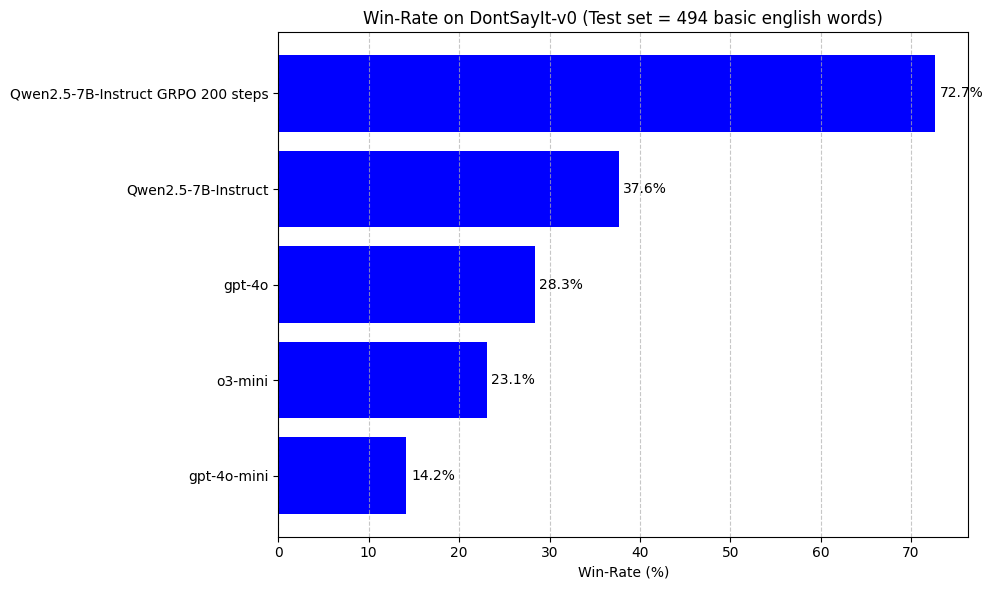

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define your data
models = [
    "gpt-4o",
    "gpt-4o-mini",
    "o3-mini",
    "Qwen2.5-7B-Instruct",
    "Qwen2.5-7B-Instruct (w reasoning prompt)",
    "Qwen2.5-7B-Instruct GRPO 100 steps (Run2)",
    "Qwen2.5-7B-Instruct GRPO 250 steps (Run1)",
]

win_rates = [
    9.230769231,
    5.384615385,
    9.230769231,
    6.538461538,
    9.615384615,
    34.23076923,
    49.61538462,
]

# 2. Create a DataFrame
df = pd.DataFrame({
    'Model Name': models,
    'Win-Rate (%)': win_rates
})

# 3. Sort by win-rate ascending for a horizontal bar chart
df_sorted = df.sort_values(by='Win-Rate (%)', ascending=True)

# 4. Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(df_sorted['Model Name'], df_sorted['Win-Rate (%)'], color='blue')
plt.xlabel('Win-Rate (%)')
plt.title('Win-Rate on TruthAndDeception-v0 (Train set = 260 games)')

# Add the values at the end of each bar
for i, v in enumerate(df_sorted['Win-Rate (%)']):
    plt.text(v + 0.5, i, f"{v:.1f}%", va='center')

plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


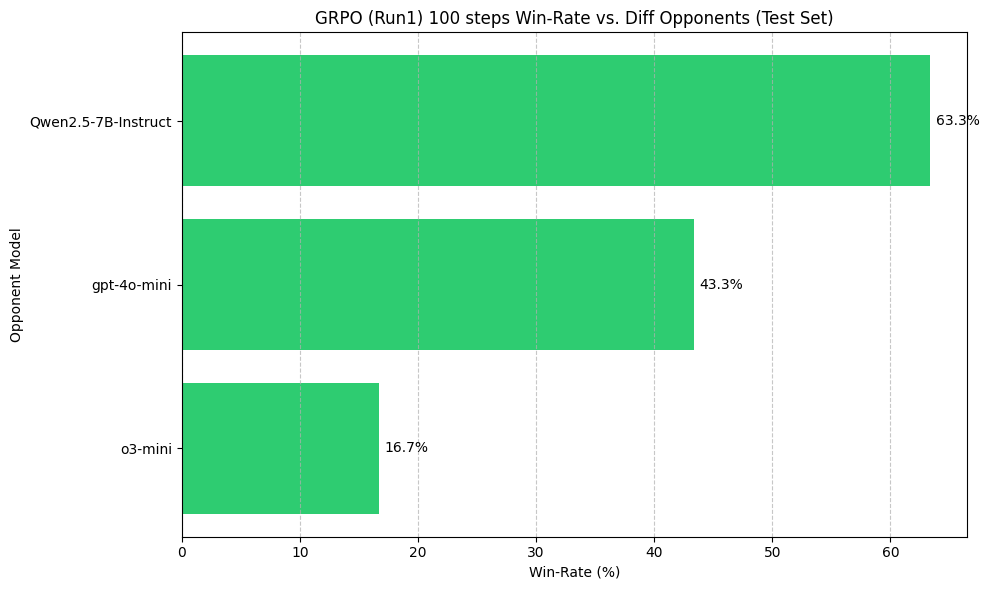

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

opponents = ['o3-mini', 'Qwen2.5-7B-Instruct', 'gpt-4o-mini']
win_rates_200 = [16.67, 63.33, 43.33]

# 2. Create a DataFrame
df = pd.DataFrame({
    'Model Name': opponents,
    'Win-Rate (%)': win_rates_200
})

# 3. Sort by win-rate ascending for a horizontal bar chart
df_sorted = df.sort_values(by='Win-Rate (%)', ascending=True)

# 4. Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(df_sorted['Model Name'], df_sorted['Win-Rate (%)'], color='#2ecc71')
plt.xlabel('Win-Rate (%)')
plt.title('GRPO (Run1) 100 steps Win-Rate vs. Diff Opponents (Test Set)')
plt.ylabel('Opponent Model')
# Add the values at the end of each bar
for i, v in enumerate(df_sorted['Win-Rate (%)']):
    plt.text(v + 0.5, i, f"{v:.1f}%", va='center')

plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



In [3]:
path = '/data/user_data/ayudhs/textarena/ExploreToM/infilled_with_llm_judge_w_goals_and_initial/search_modelctxt_1-ctxt_groupn_3_all_checkpoint-100_n_10_sent_15_p_2_m_2_r_2_maxnodes_500_maxneigh_1_10-3_0.75-5_0.5_f_acc_g_intstory_w_people_gweight_0.1_neighpri_weight-goal4_foo_dill-dst1_smlt_v3_n_10.pkl'
import pickle
with open(path, 'rb') as f:
    data = pickle.load(f)
print(data) 

ModuleNotFoundError: No module named 'belief_tracker'

In [1]:
import json
import nltk
from nltk.corpus import words

nltk.download("words")
nltk.download("averaged_perceptron_tagger_eng")


# Get all words from the en-basic list
all_words = words.words("en-basic")
print(f"Total number of words: {len(all_words)}")

# Save all words to a JSON file
output_filename = "en_basic_words.json"
with open(output_filename, 'w') as f:
    json.dump(all_words, f)

print(f"All words saved to {output_filename}")

# Print first 10 words as sample
print("Sample of first 10 words:")
print(all_words[:10])

Total number of words: 850
All words saved to en_basic_words.json
Sample of first 10 words:
['I', 'a', 'able', 'about', 'account', 'acid', 'across', 'act', 'addition', 'adjustment']


[nltk_data] Downloading package words to /home/ayudhs/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/ayudhs/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [1]:
import os
import sys
from datasets import Dataset, Features, Value
from huggingface_hub import whoami
from tqdm import tqdm

# Add the sotopia path to sys.path to import EnvironmentProfile
sys.path.append('/data/user_data/ayudhs/textarena/sotopia')

# Set up Redis connection (if needed)
os.environ["REDIS_OM_URL"] = "redis://:@localhost:6379"

# Import EnvironmentProfile and AgentProfile
from sotopia.database.persistent_profile import EnvironmentProfile, AgentProfile

def create_sotopia_environment_pk_dataset():
    """
    Create a Hugging Face dataset containing Sotopia environment profile "pk" values
    along with two different agent profile "pk" values for each row.
    This creates a cartesian product of (environment pk) x (agent_1 pk) x (agent_2 pk).
    """
    print("Fetching all environment profiles from Sotopia database...")
    
    try:
        # Get all environment profiles
        all_env_profiles = EnvironmentProfile.all()
        print(f"Found {len(all_env_profiles)} environment profiles")
        
        # Get all agent profiles
        all_agent_profiles = AgentProfile.all()
        print(f"Found {len(all_agent_profiles)} agent profiles")
        
        # Extract pk values for environments
        env_pk_data = []
        for profile in all_env_profiles:
            if profile.pk:  # Only include profiles with valid pk
                env_pk_data.append({
                    "env_pk": profile.pk,
                    "env_codename": profile.codename,
                    "env_source": profile.source,
                    "env_scenario": profile.scenario,
                    "env_relationship": str(profile.relationship),
                    "env_tag": profile.tag
                })
        
        # Extract pk values for agents
        agent_pk_data = []
        for profile in all_agent_profiles:
            if profile.pk:  # Only include profiles with valid pk
                agent_pk_data.append({
                    "agent_pk": profile.pk,
                    "agent_first_name": profile.first_name,
                    "agent_last_name": profile.last_name,
                    "agent_age": profile.age,
                    "agent_occupation": profile.occupation,
                    "agent_gender": profile.gender,
                    "agent_tag": profile.tag
                })
        
        print(f"Created dataset with {len(env_pk_data)} valid environment profiles")
        print(f"Created dataset with {len(agent_pk_data)} valid agent profiles")
        
        # Create cartesian product: (environment pk) x (agent_1 pk) x (agent_2 pk)
        # where agent_1 and agent_2 are different
        cartesian_data = []
        
        for env_data in tqdm(env_pk_data):
            for i, agent1_data in enumerate(agent_pk_data):
                for j, agent2_data in enumerate(agent_pk_data):
                    # Ensure agent_1 and agent_2 are different
                    if i != j:
                        row_data = {
                            # Environment data
                            "env_pk": env_data["env_pk"],
                            "env_codename": env_data["env_codename"],
                            "env_source": env_data["env_source"],
                            "env_scenario": env_data["env_scenario"],
                            "env_relationship": env_data["env_relationship"],
                            "env_tag": env_data["env_tag"],
                            # Agent 1 data
                            "agent1_pk": agent1_data["agent_pk"],
                            "agent1_first_name": agent1_data["agent_first_name"],
                            "agent1_last_name": agent1_data["agent_last_name"],
                            "agent1_age": agent1_data["agent_age"],
                            "agent1_occupation": agent1_data["agent_occupation"],
                            "agent1_gender": agent1_data["agent_gender"],
                            "agent1_tag": agent1_data["agent_tag"],
                            # Agent 2 data
                            "agent2_pk": agent2_data["agent_pk"],
                            "agent2_first_name": agent2_data["agent_first_name"],
                            "agent2_last_name": agent2_data["agent_last_name"],
                            "agent2_age": agent2_data["agent_age"],
                            "agent2_occupation": agent2_data["agent_occupation"],
                            "agent2_gender": agent2_data["agent_gender"],
                            "agent2_tag": agent2_data["agent_tag"]
                        }
                        cartesian_data.append(row_data)
        
        print(f"Created cartesian product with {len(cartesian_data)} combinations")
        print(f"Expected size: {len(env_pk_data)} environments × {len(agent_pk_data)} agents × {len(agent_pk_data)-1} different agents = {len(env_pk_data) * len(agent_pk_data) * (len(agent_pk_data)-1)}")
        
        # Create train/test split
        import random
        random.seed(42)  # For reproducibility
        
        # Randomly select 10% of combinations for test split (or max 1000 if dataset is very large)
        test_size = min(1000, len(cartesian_data) // 10)
        test_indices = random.sample(range(len(cartesian_data)), test_size)
        train_data = [cartesian_data[i] for i in range(len(cartesian_data)) if i not in test_indices]
        test_data = [cartesian_data[i] for i in test_indices]
        
        print(f"Created train split with {len(train_data)} combinations")
        print(f"Created test split with {len(test_data)} combinations")
        
        # Create Hugging Face dataset features
        features = Features({
            # Environment features
            "env_pk": Value("string"),
            "env_codename": Value("string"),
            "env_source": Value("string"),
            "env_scenario": Value("string"),
            "env_relationship": Value("string"),
            "env_tag": Value("string"),
            # Agent 1 features
            "agent1_pk": Value("string"),
            "agent1_first_name": Value("string"),
            "agent1_last_name": Value("string"),
            "agent1_age": Value("int32"),
            "agent1_occupation": Value("string"),
            "agent1_gender": Value("string"),
            "agent1_tag": Value("string"),
            # Agent 2 features
            "agent2_pk": Value("string"),
            "agent2_first_name": Value("string"),
            "agent2_last_name": Value("string"),
            "agent2_age": Value("int32"),
            "agent2_occupation": Value("string"),
            "agent2_gender": Value("string"),
            "agent2_tag": Value("string")
        })
        
        # Create datasets for both splits
        train_dataset = Dataset.from_list(train_data, features=features)
        test_dataset = Dataset.from_list(test_data, features=features)
        
        # Create a dataset dict with both splits
        from datasets import DatasetDict
        dataset = DatasetDict({
            "train": train_dataset,
            "test": test_dataset
        })
        
        # Get Hugging Face username
        try:
            user_info = whoami()
            username = user_info["name"]
            print(f"Using Hugging Face username: {username}")
        except Exception as e:
            print(f"Error getting Hugging Face username: {e}")
            print("Using provided username: saintlyk1d")
            username = "saintlyk1d"
        
        # Create dataset name and repo ID
        dataset_name = "sotopia-environment-agent-combinations"
        repo_id = f"{username}/{dataset_name}"
        
        # Push to Hugging Face Hub
        print(f"Pushing dataset to Hugging Face Hub as '{repo_id}'...")
        dataset.push_to_hub(repo_id)
        
        # Print sample data
        print("\nSample data from the train split:")
        for i, example in enumerate(dataset["train"][:3]):
            print(f"\nExample {i+1}:")
            print(f"Environment PK: {example['env_pk']}")
            print(f"Environment Codename: {example['env_codename']}")
            print(f"Environment Source: {example['env_source']}")
            print(f"Environment Relationship: {example['env_relationship']}")
            print(f"Environment Tag: {example['env_tag']}")
            print(f"Environment Scenario: {example['env_scenario'][:100]}...")
            print(f"Agent 1 PK: {example['agent1_pk']}")
            print(f"Agent 1 Name: {example['agent1_first_name']} {example['agent1_last_name']}")
            print(f"Agent 1 Age: {example['agent1_age']}")
            print(f"Agent 1 Occupation: {example['agent1_occupation']}")
            print(f"Agent 1 Gender: {example['agent1_gender']}")
            print(f"Agent 2 PK: {example['agent2_pk']}")
            print(f"Agent 2 Name: {example['agent2_first_name']} {example['agent2_last_name']}")
            print(f"Agent 2 Age: {example['agent2_age']}")
            print(f"Agent 2 Occupation: {example['agent2_occupation']}")
            print(f"Agent 2 Gender: {example['agent2_gender']}")
        
        print("\nSample data from the test split:")
        for i, example in enumerate(dataset["test"][:3]):
            print(f"\nExample {i+1}:")
            print(f"Environment PK: {example['env_pk']}")
            print(f"Environment Codename: {example['env_codename']}")
            print(f"Environment Source: {example['env_source']}")
            print(f"Environment Relationship: {example['env_relationship']}")
            print(f"Environment Tag: {example['env_tag']}")
            print(f"Environment Scenario: {example['env_scenario'][:100]}...")
            print(f"Agent 1 PK: {example['agent1_pk']}")
            print(f"Agent 1 Name: {example['agent1_first_name']} {example['agent1_last_name']}")
            print(f"Agent 1 Age: {example['agent1_age']}")
            print(f"Agent 1 Occupation: {example['agent1_occupation']}")
            print(f"Agent 1 Gender: {example['agent1_gender']}")
            print(f"Agent 2 PK: {example['agent2_pk']}")
            print(f"Agent 2 Name: {example['agent2_first_name']} {example['agent2_last_name']}")
            print(f"Agent 2 Age: {example['agent2_age']}")
            print(f"Agent 2 Occupation: {example['agent2_occupation']}")
            print(f"Agent 2 Gender: {example['agent2_gender']}")
        
        return dataset
        
    except Exception as e:
        print(f"Error creating dataset: {str(e)}")
        raise

if __name__ == "__main__":
    # Run the function to create the dataset
    sotopia_dataset = create_sotopia_environment_pk_dataset()

/data/user_data/ayudhs/textarena/verifiers/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/user_data/ayudhs/textarena/verifiers/.venv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "pk" in "EnvironmentList" shadows an attribute in parent "JsonModel"
  warnings.warn(


Successfully connected to Redis database redis://:@localhost:6379

Successfully initialized Redis OM object.

Fetching all environment profiles from Sotopia database...
Found 884 environment profiles
Found 40 agent profiles
Created dataset with 884 valid environment profiles
Created dataset with 40 valid agent profiles


100%|██████████| 884/884 [00:01<00:00, 851.45it/s]


Created cartesian product with 1379040 combinations
Expected size: 884 environments × 40 agents × 39 different agents = 1379040
Created train split with 1378040 combinations
Created test split with 1000 combinations
Using Hugging Face username: saintlyk1d
Pushing dataset to Hugging Face Hub as 'saintlyk1d/sotopia-environment-agent-combinations'...


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]



Sample data from the train split:

Example 1:
Error creating dataset: string indices must be integers, not 'str'


TypeError: string indices must be integers, not 'str'

In [ ]:
from datasets import load_dataset, get_preprocess_fn

ds = load_dataset("saintlyk1d/sotopia-environment-agent-combinations")["train"]
for i in range(5):
    print(ds[i])

{'env_pk': '01HPAYNSDAKRJ7RQ175QCHYAGD', 'env_codename': 'friendship_fray', 'env_source': 'social_iqa', 'env_scenario': "Agent1 overhears Agent2, a close friend, saying 'I hate my friend' in a conversation with others. Agent1 is hurt and confused, as they had always shared a good relationship. Agent2 notices the change in Agent1's behavior and realizes the misunderstanding, wanting to clarify their statement and mend the friendship.", 'env_relationship': '3', 'env_tag': '', 'agent1_pk': '01H5TNE5Q1QG5SBJ8HV7GJ0FS3', 'agent1_first_name': 'Imelda', 'agent1_last_name': 'Thorne', 'agent1_age': 35, 'agent1_occupation': 'Astrophysicist', 'agent1_gender': 'Woman', 'agent1_tag': '', 'agent2_pk': '01H5TNE5PBXGRD41HXQC1ZXHVN', 'agent2_first_name': 'Ethan', 'agent2_last_name': 'Johnson', 'agent2_age': 34, 'agent2_occupation': 'Chef', 'agent2_gender': 'Man', 'agent2_tag': ''}
{'env_pk': '01HPAYNSDAKRJ7RQ175QCHYAGD', 'env_codename': 'friendship_fray', 'env_source': 'social_iqa', 'env_scenario': "Ag

In [5]:
preprocess_fn = get_preprocess_fn("sotopia")
ds = ds.map(preprocess_fn)
for i in range(5):
    print(ds[i]["prompt"])

NameError: name 'get_preprocess_fn' is not defined